In [1]:
import yfinance as yf
import bs4 as bs
import pickle
import requests
import pandas as pd
import json
from dateutil import parser
from datetime import datetime
import os
import time
from pandas.io.json import json_normalize
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import wrds
from datetime import datetime as dt
import numpy as np
import glob, os
import csv
from matplotlib import pyplot as plt

import yakPak as yP

In [2]:
pd.set_option("display.precision", 8)
%load_ext autoreload
%autoreload 2

In [3]:
# Define start and end of download
# allows for rolling windows
start_download = '2006-04-02'#pd.to_datetime('2009-04-02' , format = '%Y-%m-%d')
end_download = '2020-06-15'#pd.to_datetime('2020-06-15', format = '%Y-%m-%d')

In [4]:
start_date = '2009-06-30'#pd.to_datetime('2009-06-02', format = '%Y-%m-%d') # Define start and end dates
end_date = '2020-02-03'#pd.to_datetime('2020-04-15', format = '%Y-%m-%d')

In [5]:
tickers_ciks= yP.save_SP500_tickers()

In [6]:
tickers = tickers_ciks['ticker'] 
tickers = [item.replace('-','.') for item in tickers]
tickers = [item.replace('.B','-A') for item in tickers]
ciks = tickers_ciks['cik']

In [7]:
changes = pd.read_excel('sp500change.xlsx')
changes['Ticker'] = changes['Ticker'].astype(str)
changes['Ticker'] = [item.replace('-','.') for item in changes['Ticker']]
changes['Ticker'] = [item.replace('.B','-A') for item in changes['Ticker']]
tickers = [x for x in tickers if x not in list(changes['Ticker'])]

In [8]:
data_yf = yf.download(tickers, start=start_download, end=end_download)

[*********************100%***********************]  232 of 232 completed

6 Failed downloads:
- ETFC: No data found, symbol may be delisted
- XLNX: No data found, symbol may be delisted
- BLL: No data found, symbol may be delisted
- MYL: No data found, symbol may be delisted
- CTL: No data found, symbol may be delisted
- TIF: No data found, symbol may be delisted


In [9]:
#ac = data_yf['Adj Close']
oco = (data_yf['Close'] - data_yf['Open'])/data_yf['Open']
oco.index = pd.to_datetime(oco.index, format = '%Y-%m-%d')

In [10]:
oco

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WM,WMB,WMT,WY,XEL,XLNX,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-04-03,0.00793650,-0.01602036,0.00392559,0.01370511,0.01478114,-0.00724635,0.01323738,0.00413488,-0.02563431,-0.00338103,...,0.00793208,-0.00511628,-0.01057753,0.00412932,0.00494235,NaN,-0.00537813,-0.00657893,-0.01763388,-0.00494031
2006-04-04,0.00052593,-0.01497565,-0.01276251,-0.00838182,0.00947868,-0.00156815,0.01581914,0.00586710,0.01310856,0.00739259,...,0.02514289,0.00281823,-0.00406936,-0.00722266,0.01035425,NaN,0.01813683,-0.01257448,0.00607705,0.01334464
2006-04-05,0.00499604,0.03863408,0.00581634,0.00400093,-0.00415046,0.01992132,0.02848448,0.00151517,0.03500916,0.01428007,...,0.00194822,0.02091080,0.00622579,0.02335280,-0.00161718,NaN,0.00859969,0.00067063,-0.00687645,0.00384015
2006-04-06,0.00917435,0.04304539,-0.02252066,0.00492272,0.00445186,0.01160394,-0.01098322,0.01673542,0.05841667,-0.01685615,...,-0.00389862,0.01997278,-0.00682593,0.01928570,-0.01027585,NaN,0.00795457,0.00876601,0.01133027,-0.00549909
2006-04-07,-0.01354871,-0.01607208,-0.02824621,-0.01819457,0.02354577,-0.02211487,-0.02960975,-0.00556505,0.03448271,-0.00838997,...,-0.02070108,-0.02312141,-0.01032257,-0.01279999,-0.01256828,NaN,-0.00712318,-0.01140180,-0.00642490,-0.01058834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-09,-0.00355200,0.03567765,-0.01089107,-0.02220541,0.00032744,0.01097908,0.00617289,-0.01903575,0.00714004,-0.01077671,...,-0.00713970,-0.02609105,-0.00205592,0.01539122,-0.00375263,NaN,0.01210286,-0.02121055,0.00589471,0.00357425
2020-06-10,-0.00564661,0.01419949,-0.03417016,0.01441943,0.01809357,-0.01054839,-0.02292605,-0.01071453,0.00424466,-0.00372636,...,-0.02112992,-0.01467716,-0.00329051,-0.03142250,0.00465322,NaN,-0.05327100,-0.05969366,-0.01404175,-0.05159959
2020-06-11,-0.04061828,-0.03838998,-0.02380205,-0.04762937,-0.03082497,-0.04389879,-0.03860530,-0.06518044,-0.05965663,-0.02245206,...,-0.03695415,-0.01783783,-0.00743864,-0.03094233,-0.02223551,NaN,-0.02840308,-0.03194700,-0.01456368,-0.03080033


In [11]:
oco = oco.dropna(axis=0, how='all')
oco = oco.dropna(axis=1)

## Rolling Window Calcs

In [12]:
oco = oco.resample('MS').ffill().dropna()

In [13]:
oco_rolling = oco.rolling(12)

In [14]:
oco_mean = oco_rolling.mean()
oco_std = oco_rolling.std()

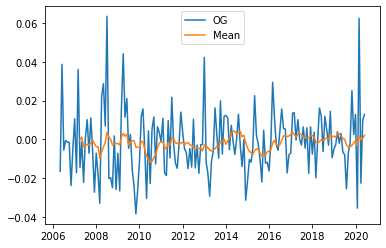

In [15]:
plt.plot(oco['AAPL'], label = 'OG')
plt.plot(oco_mean['AAPL'], label = 'Mean')
plt.legend();

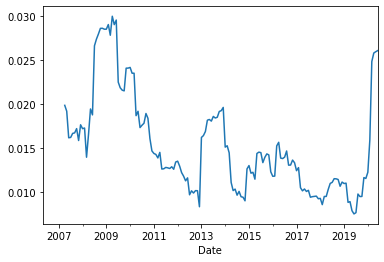

In [16]:
oco_std['AAPL'].plot();

## Augmented Dickey Fuller Test 

In [17]:
# determines if time series is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller

In [18]:
adf_results = adfuller(oco['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))
    

ADF Stats:  -6.941425133725516
p-value:  1.0227497797486815e-09
Critical Value (1%): -3.471
Critical Value (5%): -2.880
Critical Value (10%): -2.576


## Detrending

In [19]:
#oco = data_yf['Adj Close']

In [20]:
oco_log = (abs(np.log(abs(oco)**0.5))**2)

C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [21]:
oco_log = oco_log.replace([np.inf, -np.inf], np.nan).ffill()
oco_log

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,XEL,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-05-01,6.92058207,4.20747401,5.93738771,5.28847943,3.39959797,3.74705748,3.00518227,6.52397582,4.77979880,4.53880486,...,5.34938345,7.43357128,9.26635145,17.77405437,6.55321561,3.40783285,16.24756933,8.65137059,4.34349993,3.76487975
2006-06-01,5.41819207,2.64107560,17.58172168,5.08591019,10.80798713,4.80899348,3.48372034,5.28182199,3.27556583,5.52504892,...,7.86123119,5.26747630,4.82003264,8.53373967,3.88216178,5.04295131,4.93613025,3.17570365,5.36742305,4.23780913
2006-07-01,5.41819207,6.74113625,5.11547864,4.52730634,4.41986417,6.11797963,6.34090096,10.48226997,5.64642767,6.85559245,...,7.47657994,5.70196870,7.73622798,5.10884855,7.21910264,14.28664854,3.75428813,5.83691211,6.74941977,6.10811819
2006-08-01,5.41238114,13.79128694,10.80268636,11.13256820,9.48581096,4.03283992,4.63609229,4.86290205,5.70570963,6.03163581,...,3.70391109,4.64449339,6.01037708,6.60282560,4.95763431,5.30188933,4.55852622,5.15716284,6.53478741,7.52874015
2006-09-01,3.83574611,10.65773506,3.69900786,5.59724612,8.08462851,4.32610906,4.59218450,4.81027498,3.51254327,6.91081482,...,6.68794870,9.20022711,10.33402357,5.30189421,13.50507686,10.69797413,7.85006566,10.93180863,6.67402059,13.56171103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,4.09234821,2.78198765,2.52091890,3.61372949,4.68056473,4.13787487,4.29686265,4.05478999,5.38199207,8.50157743,...,2.37819074,6.45723615,4.58269787,5.02170787,5.97135602,8.84779358,4.13988522,2.98455680,5.95264971,4.11698400
2020-03-01,3.19542694,1.91998370,5.49155734,11.40164439,1.89324693,2.27516134,3.20600579,5.63571880,1.57848947,4.63554555,...,4.08142658,8.55602251,3.54985186,21.54915433,6.16323125,3.23067787,2.10981085,4.21230895,4.36306936,3.99588930
2020-04-01,5.85331847,3.58417474,3.60359156,6.72825180,3.94164238,3.58530551,6.99461125,9.65492592,2.06866694,3.00655440,...,5.98500703,3.91871711,3.04247646,4.06365870,4.30712136,7.12783409,4.01522900,5.86109376,2.55972329,3.70739419


In [22]:
oco_log_ma = oco_log.rolling(2).mean().ffill()

In [23]:
oco_log_ma

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,XEL,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-01,6.16938707,3.42427480,11.75955470,5.18719481,7.10379255,4.27802548,3.24445131,5.90289891,4.02768232,5.03192689,...,6.60530732,6.35052379,7.04319204,13.15389702,5.21768869,4.22539208,10.59184979,5.91353712,4.85546149,4.00134444
2006-07-01,5.41819207,4.69110592,11.34860016,4.80660827,7.61392565,5.46348655,4.91231065,7.88204598,4.46099675,6.19032069,...,7.66890557,5.48472250,6.27813031,6.82129411,5.55063221,9.66479992,4.34520919,4.50630788,6.05842141,5.17296366
2006-08-01,5.41528660,10.26621159,7.95908250,7.82993727,6.95283756,5.07540978,5.48849662,7.67258601,5.67606865,6.44361413,...,5.59024551,5.17323104,6.87330253,5.85583708,6.08836848,9.79426893,4.15640717,5.49703748,6.64210359,6.81842917
2006-09-01,4.62406362,12.22451100,7.25084711,8.36490716,8.78521973,4.17947449,4.61413840,4.83658852,4.60912645,6.47122531,...,5.19592989,6.92236025,8.17220033,5.95235990,9.23135558,7.99993173,6.20429594,8.04448573,6.60440400,10.54522559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,5.42069952,3.76274380,3.18980726,5.56312288,4.89171455,11.50801676,5.05544839,5.00949279,7.34430279,8.29051976,...,4.19088620,7.79307911,3.98994068,5.88932825,5.63278000,8.56701029,4.61113645,6.01164634,9.86797240,5.32877534
2020-03-01,3.64388758,2.35098568,4.00623812,7.50768694,3.28690583,3.20651811,3.75143422,4.84525439,3.48024077,6.56856149,...,3.22980866,7.50662933,4.06627487,13.28543110,6.06729364,6.03923572,3.12484804,3.59843288,5.15785953,4.05643665
2020-04-01,4.52437271,2.75207922,4.54757445,9.06494809,2.91744465,2.93023342,5.10030852,7.64532236,1.82357820,3.82104997,...,5.03321680,6.23736981,3.29616416,12.80640651,5.23517630,5.17925598,3.06251993,5.03670136,3.46139633,3.85164174


In [24]:
oco_detrend = oco_log - oco_log_ma
oco_detrend.dropna(inplace = True)

In [25]:
#mean and std of detrended data
oco_detrend_rolling = oco_detrend.rolling(12)
oco_detrend_ma = oco_detrend_rolling.mean()
oco_detrend_std = oco_detrend_rolling.std()

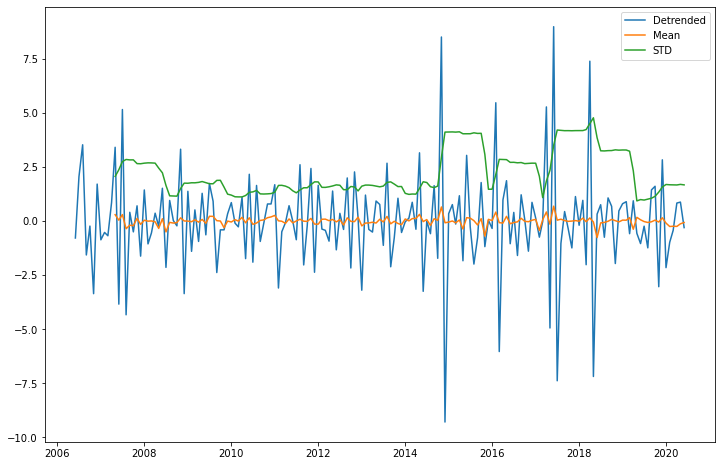

In [26]:
plt.figure(figsize=(12,8))
plt.plot(oco_detrend['AAPL'], label = 'Detrended')
plt.plot(oco_detrend_ma['AAPL'], label = 'Mean')
plt.plot(oco_detrend_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [27]:
oco_detrend['AAPL']

Date
2006-06-01   -0.78319921
2006-07-01    2.05003033
2006-08-01    3.52507534
2006-09-01   -1.56677594
2006-10-01   -0.23215134
                 ...    
2020-02-01   -0.98075615
2020-03-01   -0.43100197
2020-04-01    0.83209552
2020-05-01    0.87610825
2020-06-01   -0.30258247
Freq: MS, Name: AAPL, Length: 169, dtype: float64

In [28]:
adf_results = adfuller(oco_detrend['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))

ADF Stats:  -8.125263709876748
p-value:  1.127637030745452e-12
Critical Value (1%): -3.472
Critical Value (5%): -2.880
Critical Value (10%): -2.576


In [29]:
oco_detrend = oco_detrend[start_date:end_date]

In [30]:
#export detrended adjClose
oco_detrend.T.to_csv('Export/oco_detrend.csv') 

## Differencing

In [31]:
oco_log_diff = oco_log.diff(periods=3).dropna()

In [32]:
oco_diff_rolling = oco_log_diff.rolling(12)
oco_diff_ma = oco_diff_rolling.mean()
oco_diff_std = oco_diff_rolling.std()

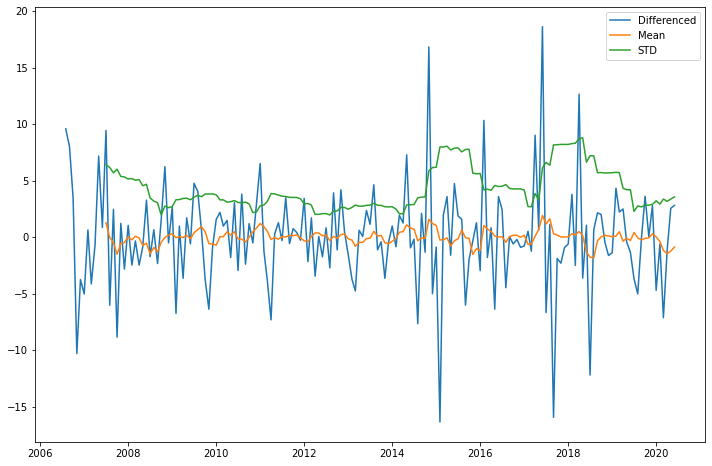

In [33]:
plt.figure(figsize=(12,8))
plt.plot(oco_log_diff['AAPL'], label = 'Differenced')
plt.plot(oco_diff_ma['AAPL'], label = 'Mean')
plt.plot(oco_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [34]:
#export detrended adjClose
oco_log_diff.T.to_csv('Export/oco_diff.csv')

In [35]:
oco_log_diff = oco_log_diff[start_date:end_date]

In [36]:
oco_log_diff

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,XEL,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,2.81890688,4.76826043,-1.34285348,0.36353500,3.06550434,5.82657020,0.98262615,5.10659832,1.16049333,-0.10686838,...,0.42243861,0.63172906,0.41038116,4.63824272,6.57311398,-6.11543694,7.52352336,0.47436553,3.28223595,1.44410549
2009-08-01,9.53586472,4.03456724,3.15762634,-1.07422215,6.66023904,-0.27526034,7.41295511,0.16390045,10.50652059,2.36184968,...,-1.67323929,8.87759159,4.12937354,2.50904683,0.93153043,0.19232644,10.35838394,1.99185079,2.61638553,-0.21359514
2009-09-01,1.17250890,0.55158515,5.96348984,6.21307111,4.10091846,-0.93170826,-0.34898011,0.58297236,0.69813843,6.04006955,...,0.41879908,5.91840075,1.25991407,2.51901682,0.22042611,6.54611349,1.98538143,-0.73079913,1.03373528,-2.05633023
2009-10-01,8.09762920,-3.74027474,0.78852490,-1.62875697,-0.88062127,-9.94536658,2.60508615,-2.21410880,1.47757136,0.02916081,...,0.28240059,-1.92324790,-1.24208306,2.90115791,-5.07880826,3.01488834,-6.22307420,-1.27860153,-1.68414349,-1.60036250
2009-11-01,-9.76241851,-6.38024388,-3.50073738,2.73354759,-6.62026790,-3.23085625,-6.61322309,-0.61382861,-11.88486155,-2.84901973,...,-0.15263073,-9.89257067,-4.67066774,-3.53801119,-2.41871521,-0.27538510,-11.51167895,-0.98751003,-4.89671497,-2.87106802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,-5.45303717,3.62058745,-1.95802980,-5.15957870,-3.56170451,-1.53195466,-7.58309579,-1.06957954,-0.64111732,2.28139761,...,-2.53105165,2.89446626,-0.84605558,-0.79013222,-3.53986240,1.06566974,-2.72873792,-3.79852677,1.69619131,-3.22784891
2019-11-01,0.00831229,0.02942556,-0.46820339,-0.63023867,-1.96428122,1.05734186,-5.26802526,2.23825670,0.91001316,2.48520498,...,0.98911431,-1.41712998,-0.81244680,3.24523146,-1.26596883,3.70283302,-0.03857961,-0.58568263,-2.61631953,3.11262560
2019-12-01,2.01497783,2.80665772,-1.70826216,-0.00615429,2.90355876,1.79469570,-1.14431273,10.50182833,-1.60493520,3.32839676,...,-3.87600753,5.88012518,1.63797005,8.75079914,-1.35196125,1.46175356,-1.31588757,-1.37803487,4.26144141,-9.06452604


## Seasonal Decomposition

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
oco_log

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,XEL,XOM,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-05-01,6.92058207,4.20747401,5.93738771,5.28847943,3.39959797,3.74705748,3.00518227,6.52397582,4.77979880,4.53880486,...,5.34938345,7.43357128,9.26635145,17.77405437,6.55321561,3.40783285,16.24756933,8.65137059,4.34349993,3.76487975
2006-06-01,5.41819207,2.64107560,17.58172168,5.08591019,10.80798713,4.80899348,3.48372034,5.28182199,3.27556583,5.52504892,...,7.86123119,5.26747630,4.82003264,8.53373967,3.88216178,5.04295131,4.93613025,3.17570365,5.36742305,4.23780913
2006-07-01,5.41819207,6.74113625,5.11547864,4.52730634,4.41986417,6.11797963,6.34090096,10.48226997,5.64642767,6.85559245,...,7.47657994,5.70196870,7.73622798,5.10884855,7.21910264,14.28664854,3.75428813,5.83691211,6.74941977,6.10811819
2006-08-01,5.41238114,13.79128694,10.80268636,11.13256820,9.48581096,4.03283992,4.63609229,4.86290205,5.70570963,6.03163581,...,3.70391109,4.64449339,6.01037708,6.60282560,4.95763431,5.30188933,4.55852622,5.15716284,6.53478741,7.52874015
2006-09-01,3.83574611,10.65773506,3.69900786,5.59724612,8.08462851,4.32610906,4.59218450,4.81027498,3.51254327,6.91081482,...,6.68794870,9.20022711,10.33402357,5.30189421,13.50507686,10.69797413,7.85006566,10.93180863,6.67402059,13.56171103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,4.09234821,2.78198765,2.52091890,3.61372949,4.68056473,4.13787487,4.29686265,4.05478999,5.38199207,8.50157743,...,2.37819074,6.45723615,4.58269787,5.02170787,5.97135602,8.84779358,4.13988522,2.98455680,5.95264971,4.11698400
2020-03-01,3.19542694,1.91998370,5.49155734,11.40164439,1.89324693,2.27516134,3.20600579,5.63571880,1.57848947,4.63554555,...,4.08142658,8.55602251,3.54985186,21.54915433,6.16323125,3.23067787,2.10981085,4.21230895,4.36306936,3.99588930
2020-04-01,5.85331847,3.58417474,3.60359156,6.72825180,3.94164238,3.58530551,6.99461125,9.65492592,2.06866694,3.00655440,...,5.98500703,3.91871711,3.04247646,4.06365870,4.30712136,7.12783409,4.01522900,5.86109376,2.55972329,3.70739419


In [39]:
oco_residual = oco_log.apply(lambda x: seasonal_decompose(x, model = 'additive', period = 12).resid, axis = 0).dropna()


In [40]:
oco_residual = oco_residual[start_date:end_date]

In [41]:
#export detrended adjClose
oco_residual.T.to_csv('Export/oco_resid.csv')

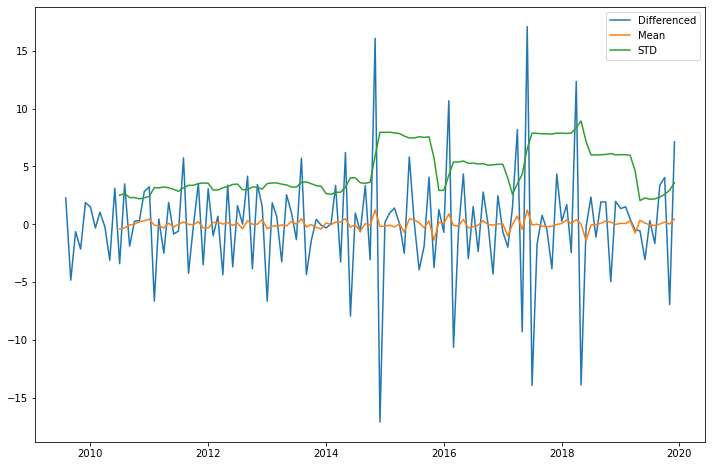

In [42]:
oco_log_diff = oco_residual.diff().dropna()

#mean and std of differenced data
oco_diff_rolling = oco_log_diff.rolling(12)
oco_diff_ma = oco_diff_rolling.mean()
oco_diff_std = oco_diff_rolling.std()

# plot the stationary data
plt.figure(figsize=(12,8))
plt.plot(oco_log_diff['AAPL'], label = 'Differenced')
plt.plot(oco_diff_ma['AAPL'], label = 'Mean')
plt.plot(oco_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');